[View in Colaboratory](https://colab.research.google.com/github/sergeivolodin/ProbabilisticNeuronFailureCode/blob/master/DropoutErrorVarianceKerasColab.ipynb)

In [1]:
# keras, np, plt imports
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.core import Lambda
from keras.optimizers import SGD
from keras.initializers import Constant
from keras import backend as K
from keras.utils import plot_model
from functools import partial
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
def PermanentDropout(p_fail):
  """ Make dropout work when using predict(), not only when using train """
  return Lambda(lambda x: K.dropout(x, level=p_fail))
  
def create_model(p_fails, layer_weights, layer_biases, KLips):
  """ Create some simple network with given dropout prob, weights and Lipschitz coefficient for sigmoid """
  
  # checking if length matches
  assert(len(p_fails) == len(layer_weights))
  assert(len(layer_biases) == len(layer_weights))
  
  # creating model
  model = Sequential()
  
  # adding layers
  for i, (p_fail, w, b) in enumerate(zip(p_fails, layer_weights, layer_biases)):
    # is last layer (with output)?
    is_last = i + 1 == len(p_fails)
    
    # adding dense layer with sigmoid for hidden and linear for last layer
    model.add(Dense(w.shape[1], input_shape = (w.shape[0], ),
                    kernel_initializer = Constant(w),
                    #activation = 'linear' if is_last else get_custom_activation(KLips),
                    activation = get_custom_activation(KLips),
                    bias_initializer = Constant(b)))
    
    # adding dropout to all layers but last
    if not is_last and p_fail > 0:
      model.add(PermanentDropout(p_fail))
  
  # compiling model with some loss and some optimizer (they are unused)
  model.compile(loss='binary_crossentropy', optimizer = 'sgd')
  #model.summary()
  return model

# calculate first norm
norm1 = partial(np.linalg.norm, ord = 1)

# calculate second norm
norm2 = partial(np.linalg.norm, ord = 2)

def dot_abs(x, y):
  """ Dot product between absolute values of vectors x, y """
  return np.dot(np.abs(x), np.abs(y))

def norm1_minus_dot_abs(x, y):
  """ Product of first norms - dot product between absolute values """
  return norm1(x) * norm2(y) - dot_abs(x, y)

def get_custom_activation(KLips):
  """ Get custom sigmoid activation with given Lipschitz constant """
  def custom_activation(x):
    return K.sigmoid(4 * KLips * x)
  return custom_activation

class Experiment():
  """ One experiment on neuron crash, contains a fixed weights network """
  def __init__(self, N, P, KLips):
    """ Initialize using given number of neurons per layer N (array), probability of failure P, and the Lipschitz coefficient """
    
    # checking if the length is correct. Last layer cannot have failures so P is shorter than N
    assert(len(N) == len(P) + 1)
    
    # sqving N, last layer has 1 neuron
    self.N = N + [1]
    
    # saving P, last layer has zero probability of failure
    self.P = P + [0]
    
    # maximal value of output from neuron (1 since using sigmoid)
    self.C = 1.
    
    # saving K
    self.K = KLips
    
    # populating models
    self.init_weights()
    
  def init_weights(self):
    """ Fill in the weights and initialize models """
    
    # array with weight matrices
    self.W = []
    
    # array with biases
    self.B = []
    
    # loop over layers
    for i in range(1, len(self.N)):
      # creating w and b
      w = np.random.randn(self.N[i - 1], self.N[i]) / (self.N[i - 1]) * 5
      b = np.random.randn(self.N[i]) / self.N[i] ** 2
      
      # adding them to the array
      self.W.append(w)
      self.B.append(b)
      
    # creating "crashing" model
    self.model = create_model(self.P, self.W, self.B, self.K)
    
    # creating correct model
    self.model_no_dropout = create_model([0] * len(self.P), self.W, self.B, self.K)
    
  def predict_no_dropout(self, data):
    """ Get correct network output for a given input vector """
    return self.model_no_dropout.predict(np.array([data]))[0][0]
  
  def predict(self, data, repetitions = 100):
    """ Get crashed network outputs for given input vector and number of repetitions """
    data = np.repeat(np.array([data]), repetitions, axis = 0)
    return self.model.predict(data).T[0]
  
  def plot_error(experiment, errors):
    """ Plot the histogram of error  """
    
    # plotting
    plt.title('Network error histogram plot')
    plt.xlabel('Network output error')
    plt.ylabel('Frequency')
    plt.hist(errors, density = True)
    #plt.plot([true, true], [0, 1], label = 'True value')
    #plt.legend()
    plt.show()
  
  def get_error(experiment, inp, repetitions = 100):
    """ Return error between crashed and correct networks """
    return experiment.predict(inp, repetitions = repetitions) - experiment.predict_no_dropout(inp)
  
  def get_wb(self, layer):
    """ Get weight and bias matrix """
    return np.vstack((self.W[layer], self.B[layer]))
  
  def get_max_f(self, layer, func):
    """ Maximize func(weights) over neurons in layer """
    wb = self.get_wb(layer)
    res = [func(w_neuron) for w_neuron in wb.T]
    return np.max(res)
  
  def get_max_f_xy(self, layer, func):
    """ Maximize func(w1, w2) over neurons in layer """
    wb = self.get_wb(layer)
    res = [func(w_neuron1, w_neuron2) for w_neuron1 in wb.T for w_neuron2 in wb.T]
    return np.max(res)
  
  def get_mean_std_error(self):
    """ Get theoretical bound for mean and std of error given weights """
    
    # Expectation of error
    EDelta = 0.
    
    # Expectation of error squared
    EDelta2 = 0.
    
    # Array of expectations
    EDeltaArr = [0]
    
    # Array of expectations of squares
    EDelta2Arr = [0]
    
    # Loop over layers
    for layer in range(len(self.W)):
      # probability of failure of a single neuron
      p_l = self.P[layer]
      
      # maximal 1-norm of weights
      w_1_norm = self.get_max_f(layer, norm1)
      
      # alpha from article for layer
      alpha = self.get_max_f_xy(layer, dot_abs)
      
      # beta from article for layer
      beta = self.get_max_f_xy(layer, norm1_minus_dot_abs)
      
      # a, b from article for EDelta2 (note that old EDelta is used)
      a = self.C ** 2 * p_l * (alpha + p_l * beta) + 2 * self.K * self.C * p_l * (1 - p_l) * beta * EDelta
      b = self.K ** 2 * (1 - p_l) * (alpha + (1 - p_l) * beta)
      
      # Updating EDelta2
      EDelta2 = a + b * EDelta2
      
      # Updating EDelta
      EDelta = p_l * w_1_norm * self.C + self.K * w_1_norm * (1 - p_l) * EDelta
      
      # Adding new values to arrays
      EDeltaArr.append(EDelta)
      EDelta2Arr.append(EDelta2)
      
    # Debug output
    #print(EDeltaArr)
    #print(EDelta2Arr)
    
    # Returning mean and sqrt(std^2)
    return EDelta, EDelta2 ** 0.5
  
def run_experiment(L = 3, N = 10, p = 0.1, repetitions = 10000, inputs = 50, K = 0.1, do_plot = True, do_print = True, do_tqdm = True):
  """ Run a single experiment with a fixed network """
  
  # Creating an experiment
  experiment = Experiment([N] * L, [p] * (L - 1), K)
  #print(experiment.W)
  #print(experiment.B)
  
  # Creating input data
  data = np.random.randn(inputs, N) / K * 10 # TODO: Results in VERY LOW true value variance, How to fix?
  #data = np.random.randint(-1, 1, size = (inputs, N))
  
  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]
  
  #print(data)
  #print(trues)
  
  # Running the experiment
  tqdm_ = tqdm if do_tqdm else (lambda x : x)
  errors = [experiment.get_error(value, repetitions = repetitions) for value in tqdm_(data)]
  
  # Computing Maximal Absolute Mean/Std Error over 
  errors_abs = np.abs(errors)
  means = np.mean(errors_abs, axis = 1)
  stds = np.std(errors_abs, axis = 1)
  mean_exp = np.max(means)
  std_exp = np.max(stds)
  
  # Computing bound values
  mean_bound, std_bound = experiment.get_mean_std_error()
  
  # Plotting the error histogram
  if do_plot:
    experiment.plot_error(np.array(errors).reshape(-1))
  
  # Printing results summary
  if do_print:
    print('Error; maximal over inputs, average over dropout:')
    print('True values array mean: %f variance %f' % (np.mean(trues), np.std(trues)))
    print('Experiment %f Std %f' % (mean_exp, std_exp))
    print('Equation   %f Std %f' % (mean_bound, std_bound))
    print('Tightness  %.1f%% Std %.1f%%' % (100 * mean_exp / mean_bound, 100 * std_exp / std_bound))
    
  # Returning summary
  return mean_exp, std_exp, mean_bound, std_bound, np.std(trues)

100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


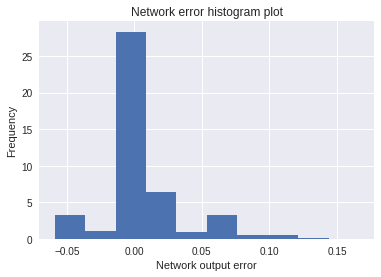

Error; maximal over inputs, average over dropout:
True values array mean: 0.283240 variance 0.000000
Experiment 0.022211 Std 0.022674
Equation   0.560729 Std 0.379969
Tightness  4.0% Std 6.0%


(0.022210605,
 0.022673674,
 0.5607289392691668,
 0.3799692378353391,
 2.416746e-07)

In [3]:
run_experiment(inputs = 50, N = 5, L = 10)

In [4]:
Ls = range(2, 11)
results = [run_experiment(inputs = 5, L = L, N = 10, K = 0.01, do_tqdm = False, do_plot = False, do_print = False) for L in tqdm(Ls)]

100%|██████████| 9/9 [00:30<00:00,  4.01s/it]


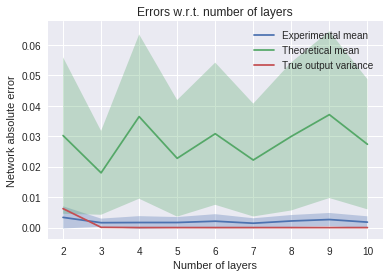

In [5]:
mean_exp, std_exp, mean_bound, std_bound, std_true = [np.array(x) for x in zip(*results)]
plt.figure()
plt.title('Errors w.r.t. number of layers')
plt.xlabel('Number of layers')
plt.ylabel('Network absolute error')
plt.plot(Ls, mean_exp, label = 'Experimental mean')
plt.fill_between(Ls, mean_exp - std_exp, mean_exp + std_exp, alpha = 0.3)
plt.plot(Ls, mean_bound, label = 'Theoretical mean')
plt.fill_between(Ls, mean_bound - std_bound, mean_bound + std_bound, alpha = 0.3)
plt.plot(Ls, std_true, label = 'True output variance')
plt.legend()
plt.show()